In [39]:
from pathlib import Path

import matplotlib as mpl
import pandas as pd
import wmfdata as wmf

In [17]:
wmf.charting.set_mpl_style()

In [3]:
SPARK_PARTITION_DATE = (
    "CONCAT("
        "CAST(year AS STRING), '-', "
        "LPAD(CAST(month AS STRING), 2, '0'), '-', "
        "LPAD(CAST(day AS STRING), 2, '0')"
    ")"
)

today = pd.Timestamp.now().round(freq="D")
yesterday = today - pd.Timedelta(1, unit="day")
query_range = pd.date_range(end=yesterday, periods=90, freq="D")

In [ ]:
fragments = []

for day in query_range:
    day_str = day.strftime("%Y-%m-%d")
    
    data = wmf.spark.run(
        f"""
        SELECT
            '{day_str}' AS time,
            access_method,
            SUM(CAST(referer LIKE '%tiktok.com%' AS INT)) AS tiktok_referrer_pageviews,
            SUM(CAST(referer = "-" AS INT)) AS blank_referrer_pageviews
        FROM wmf.webrequest
        WHERE
            webrequest_source = "text"
            AND is_pageview
            AND year = {day.year}
            AND month = {day.month}
            AND day = {day.day}
        GROUP BY
            access_method
        """,
        session_type="yarn-large"
    )
    
    fragments.append(data)
    
    now = pd.Timestamp.now().round(freq="S")
    with Path("tiktok_query_progress.txt").open("a") as f:
        f.write(f"[{now}] Finished query for {day_str}.\n")

possible_tiktok_traffic = pd.concat(fragments)

In [5]:
possible_tiktok_traffic

,time,access_method,tiktok_referrer_pageviews,blank_referrer_pageviews
0,2021-07-15,desktop,16,200279457
1,2021-07-15,mobile app,0,5426045
2,2021-07-15,mobile web,38730,66836144
0,2021-07-16,desktop,14,197892510
1,2021-07-16,mobile app,0,5499787
...,...,...,...,...
1,2021-10-11,mobile app,0,6128868
2,2021-10-11,mobile web,62128,68879851
0,2021-10-12,desktop,23,166776212
1,2021-10-12,mobile app,0,5605751


In [44]:
(
    possible_tiktok_traffic
    .drop("time", axis=1)
    .groupby("access_method")
    .sum()
)

,tiktok_referrer_pageviews,blank_referrer_pageviews
access_method,,
desktop,1725,17884069761
mobile app,0,560606138
mobile web,4137706,6213386988


In [12]:
mw_ptt = (
    possible_tiktok_traffic
    .query("access_method == 'mobile web'")
    .drop("access_method", axis="columns")
    .assign(time=lambda df: pd.to_datetime(df["time"]))
    .set_index("time")
)

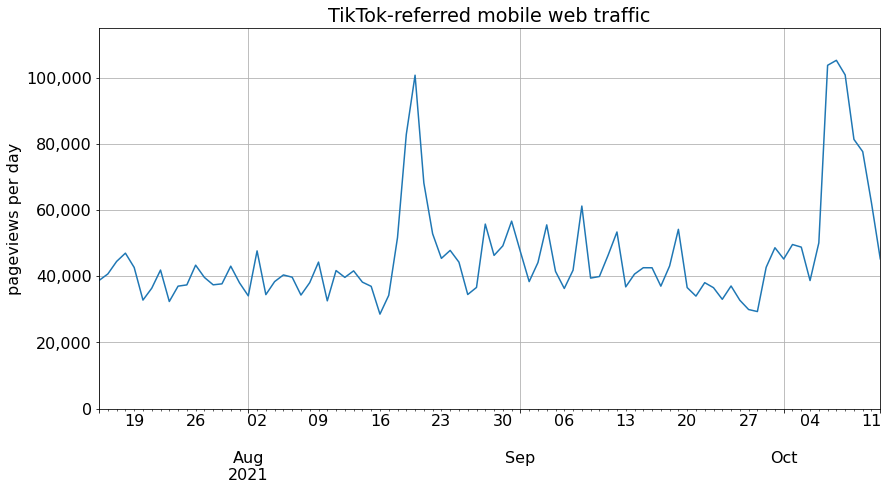

In [43]:
ax = mw_ptt["tiktok_referrer_pageviews"].plot(
    xlabel="",
    ylabel="pageviews per day",
    ylim=(0, 115000),
    title="TikTok-referred mobile web traffic"
);

ax.yaxis.set_major_formatter(wmf.charting.comma_fmt)

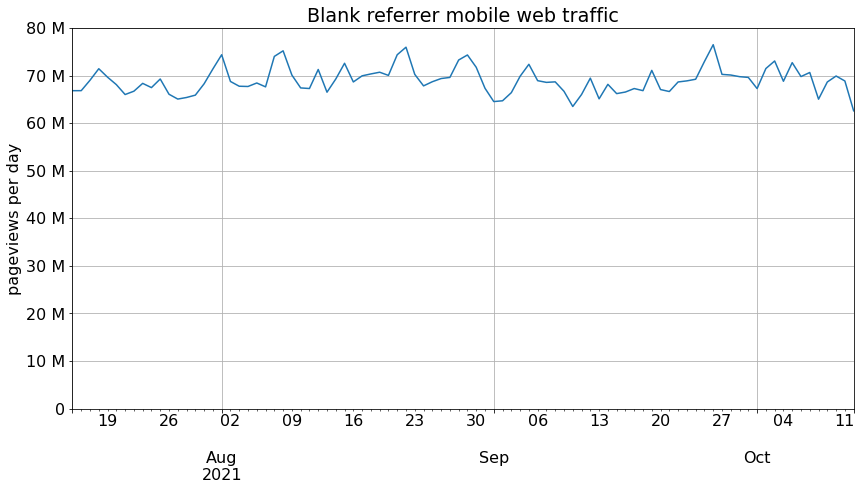

In [41]:
ax = mw_ptt["blank_referrer_pageviews"].plot(
    xlabel="",
    ylabel="pageviews per day",
    ylim=(0, 80000000),
    title="Blank referrer mobile web traffic"
)

ax.yaxis.set_major_formatter(mpl.ticker.EngFormatter())